In [132]:
from __future__ import print_function

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import sys
#%matplotlib inline

from keras.layers import Input, Dense, Lambda, Flatten, Reshape, Conv2D, MaxPooling2D, UpSampling2D
from keras.layers import Conv2DTranspose, LeakyReLU, BatchNormalization, Activation
from keras.models import Model
from keras import losses, regularizers
from keras import backend as K
from keras import metrics

from vis.visualization import visualize_activation, visualize_activation_with_losses
from vis.regularizers import TotalVariation, LPNorm
from vis.losses import ActivationMaximization
from vis.input_modifiers import Jitter
                                                                   
import h5py
import importlib

sys.path.append('/home/bastien/Documents/StageCMM/Auto-encoders/SourceCode')

import bastien_utils
import custom_regularizers

In [11]:
importlib.reload(bastien_utils)

<module 'bastien_utils' from '/home/bastien/Documents/StageCMM/Auto-encoders/SourceCode/bastien_utils.py'>

In [12]:
FILE_PATH = "../"


img_rows, img_cols, img_chns = 28, 28, 1

if K.image_data_format() == 'channels_first':
    original_img_size = (img_chns, img_rows, img_cols)
else:
    original_img_size = (img_rows, img_cols, img_chns)

In [56]:
data = bastien_utils.load_data(FILE_PATH, train=True, test=True, subsetTest=True)
x_train, y_train, x_test, y_test, x_small, y_small = data
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('x_small shape:', x_small.shape)

x_train shape: (60000, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)
x_small shape: (10, 28, 28, 1)


In [28]:
def kl_divergence(output):
    s_hat = K.mean(output, 0)
    s = 0.01
    s_hat += 10 ** -5
    val = s * K.log(s/s_hat) + (1 - s) * K.log((1 - s)/(1 - s_hat))
    return val

In [23]:
a = kl_divergence

In [31]:
dir_models='../ShallowAE/Sparse/Models/'
model_path= dir_models + 'kl_dim100.h5'
autoencoder, encoder, decoder = bastien_utils.load_AE(model_path, custom_objects={'kl_divergence':kl_divergence})

TypeError: kl_divergence() missing 1 required positional argument: 'output'

In [33]:
from keras.utils import CustomObjectScope
from keras.models import load_model

with CustomObjectScope({'kl_divergence':kl_divergence}):
    autoencoder = load_model(model_path)

TypeError: kl_divergence() missing 1 required positional argument: 'output'

In [36]:
latent_dim = 100


input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format
x = Flatten()(input_img)

with CustomObjectScope({'kl_divergence':kl_divergence}):
    encoded = Dense(latent_dim, activation='sigmoid',  activity_regularizer='kl_divergence')(x)

encoder = Model(input_img, encoded, name='encoder')
encoder.summary()

encoded_img = Input(shape=(latent_dim,))  # adapt this if using `channels_first` image data format

x = Dense(28*28)(encoded_img)
x = LeakyReLU(alpha=0.1)(x)
decoded = Reshape((28,28,1))(x)

decoder = Model(encoded_img, decoded, name='decoder')
decoder.summary()

encoded = encoder(input_img)
decoded = decoder(encoded)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')
autoencoder.summary()

TypeError: kl_divergence() missing 1 required positional argument: 'output'

In [57]:
from keras.regularizers import Regularizer

class KL_divergence(Regularizer):
    """KL divergence for Sparsity regularization.
    # Arguments
        beta: Float; Weight of the kl_regularizer.
        rho: Float; Sparsity Parameter.
    """

    def __init__(self, beta=1, rho=0.1):
        self.beta = K.cast_to_floatx(beta)
        self.rho = K.cast_to_floatx(rho)

    def __call__(self, x):
        s_hat = K.mean(x, 0)
        s_hat += 10 ** -5
        val = self.rho * K.log(self.rho/s_hat) + (1 - self.rho) * K.log((1 - self.rho)/(1 - s_hat))
        return self.beta*val

    def get_config(self):
        return {'beta': float(self.beta),
                'rho': float(self.rho)}

    
def kl_divergence(beta=1, rho=0.1):
    return KL_divergence(beta=beta, rho=rho)

In [58]:
latent_dim = 100


input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format
x = Flatten()(input_img)

#with CustomObjectScope({'kl_divergence':kl_divergence}):
encoded = Dense(latent_dim, activation='sigmoid',  activity_regularizer=kl_divergence(beta=1., rho=0.1))(x)

encoder = Model(input_img, encoded, name='encoder')
encoder.summary()

encoded_img = Input(shape=(latent_dim,))  # adapt this if using `channels_first` image data format

x = Dense(28*28)(encoded_img)
x = LeakyReLU(alpha=0.1)(x)
decoded = Reshape((28,28,1))(x)

decoder = Model(encoded_img, decoded, name='decoder')
decoder.summary()

encoded = encoder(input_img)
decoded = decoder(encoded)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 100)               78500     
Total params: 78,500
Trainable params: 78,500
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 100)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 784)               79184     
_________________________________________________________________
leaky_

In [59]:
autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test)
                )

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 8s 126us/step - loss: 0.0649 - val_loss: 0.0312
Epoch 2/100
60000/60000 [==============================] - 6s 106us/step - loss: 0.0277 - val_loss: 0.0247
Epoch 3/100
60000/60000 [==============================] - 6s 105us/step - loss: 0.0222 - val_loss: 0.0235
Epoch 4/100
60000/60000 [==============================] - 6s 105us/step - loss: 0.0194 - val_loss: 0.0203
Epoch 5/100
60000/60000 [==============================] - 6s 105us/step - loss: 0.0178 - val_loss: 0.0175
Epoch 6/100
60000/60000 [==============================] - 6s 105us/step - loss: 0.0168 - val_loss: 0.0163
Epoch 7/100
60000/60000 [==============================] - 6s 107us/step - loss: 0.0159 - val_loss: 0.0150
Epoch 8/100
60000/60000 [==============================] - 6s 106us/step - loss: 0.0154 - val_loss: 0.0155
Epoch 9/100
60000/60000 [==============================] - 6s 106us/step - loss: 0.0148 - val_

60000/60000 [==============================] - 7s 117us/step - loss: 0.0104 - val_loss: 0.0114
Epoch 77/100
60000/60000 [==============================] - 7s 113us/step - loss: 0.0105 - val_loss: 0.0105
Epoch 78/100
60000/60000 [==============================] - 7s 114us/step - loss: 0.0104 - val_loss: 0.0100
Epoch 79/100
60000/60000 [==============================] - 7s 114us/step - loss: 0.0105 - val_loss: 0.0100
Epoch 80/100
60000/60000 [==============================] - 7s 110us/step - loss: 0.0103 - val_loss: 0.0102
Epoch 81/100
60000/60000 [==============================] - 6s 108us/step - loss: 0.0103 - val_loss: 0.0101
Epoch 82/100
60000/60000 [==============================] - 6s 106us/step - loss: 0.0105 - val_loss: 0.0130
Epoch 83/100
60000/60000 [==============================] - 6s 106us/step - loss: 0.0104 - val_loss: 0.0105
Epoch 84/100
60000/60000 [==============================] - 6s 106us/step - loss: 0.0103 - val_loss: 0.0111
Epoch 85/100
60000/60000 [===============

In [60]:
H = encoder.predict(x_test)
x_reconstruction_test = decoder.predict(H) 

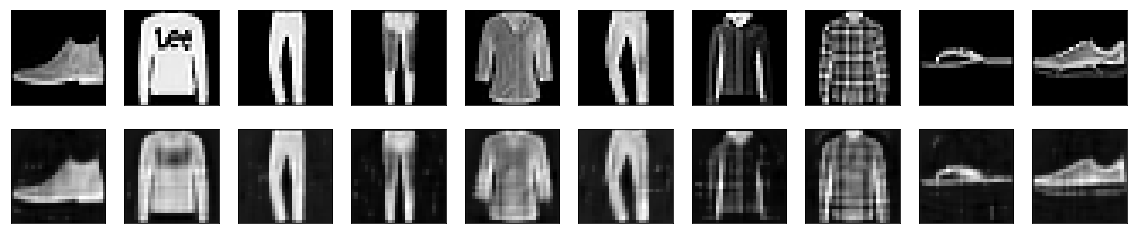

In [61]:
n = 10  # how many images we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i, :,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  
    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(x_reconstruction_test[i,:,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)    
plt.show()

In [62]:
W= encoder.get_weights()[0]
atoms = W.reshape((28,28,100))

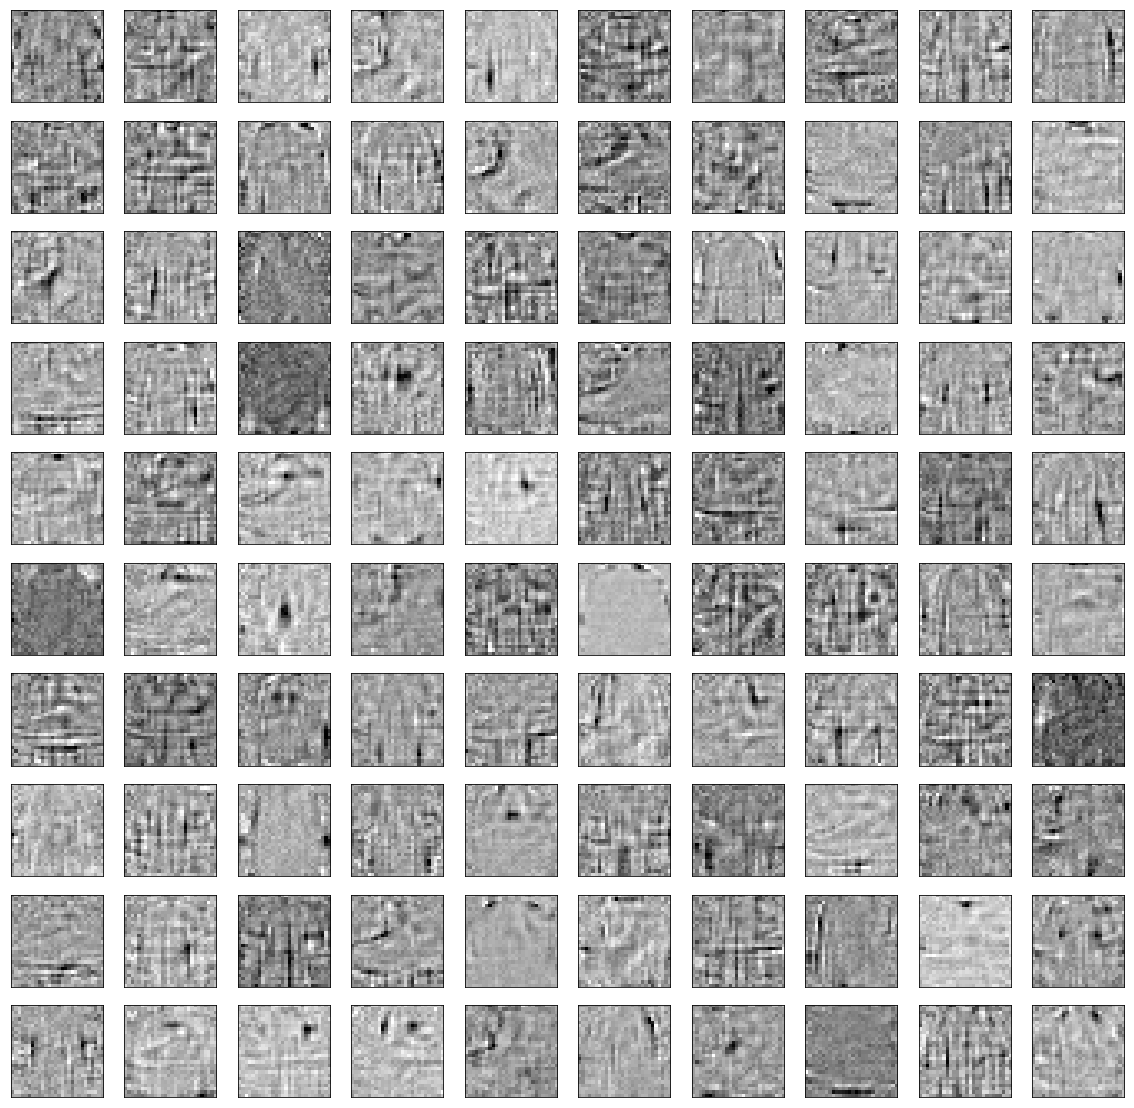

In [63]:
n = 100  
plt.figure(figsize=(20, 20))
for i in range(n):
    ax = plt.subplot(10, 10, i + 1)
    plt.imshow(atoms[:, :,i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [77]:
def atom_images(encoder):
    """
    Return the atom images of a shallow encoder.
    """
    W= encoder.get_weights()[0]
    nbAtoms = W.shape[1]
    W = keras.utils.normalize(W, axis=0, order=2)
    atoms = W.reshape((28,28,nbAtoms))
    return atoms

In [99]:
 encoder.get_output_shape_at(1)[-1]

100

In [93]:
l.get_output_shape_at(0)[-1]

100

In [106]:
encoder.layers[-1]

In [120]:
from vis.visualization import visualize_activation, visualize_activation_with_losses
from vis.regularizers import TotalVariation, LPNorm

def activation_maximization(encoder):
    nbHidden = encoder.get_output_shape_at(0)[-1]
    atoms = np.zeros((nbHidden, 28,28))
    for i in range(nbHidden):
        losses = [
            (ActivationMaximization(encoder.layers[-1], [i]), 10),
            (LPNorm(encoder.get_input_at(0)), 1),
            (TotalVariation(encoder.get_input_at(0)), 1)
        ]
        x_viz = visualize_activation_with_losses(encoder.get_input_at(0), losses=losses)
        atoms[i] = 10*np.copy(x_viz[:,:,0])
    return atoms

In [78]:
atoms = atom_images(encoder)

In [79]:
atoms.shape

(28, 28, 100)

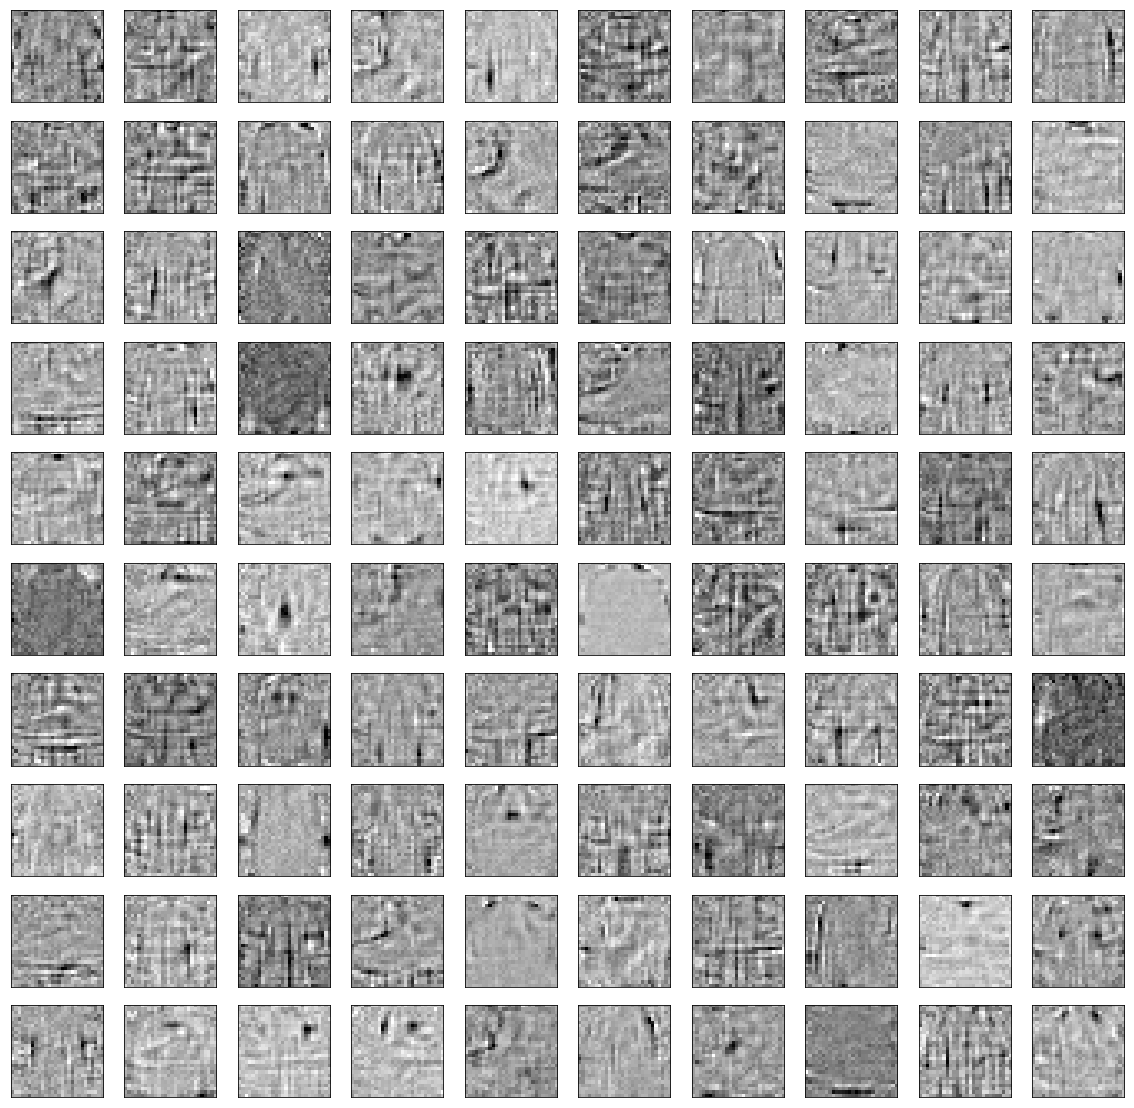

In [80]:
n = 100  
plt.figure(figsize=(20, 20))
for i in range(n):
    ax = plt.subplot(10, 10, i + 1)
    plt.imshow(atoms[:, :,i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [121]:
atoms = activation_maximization(encoder)

In [117]:
atoms.shape

(100, 28, 28)

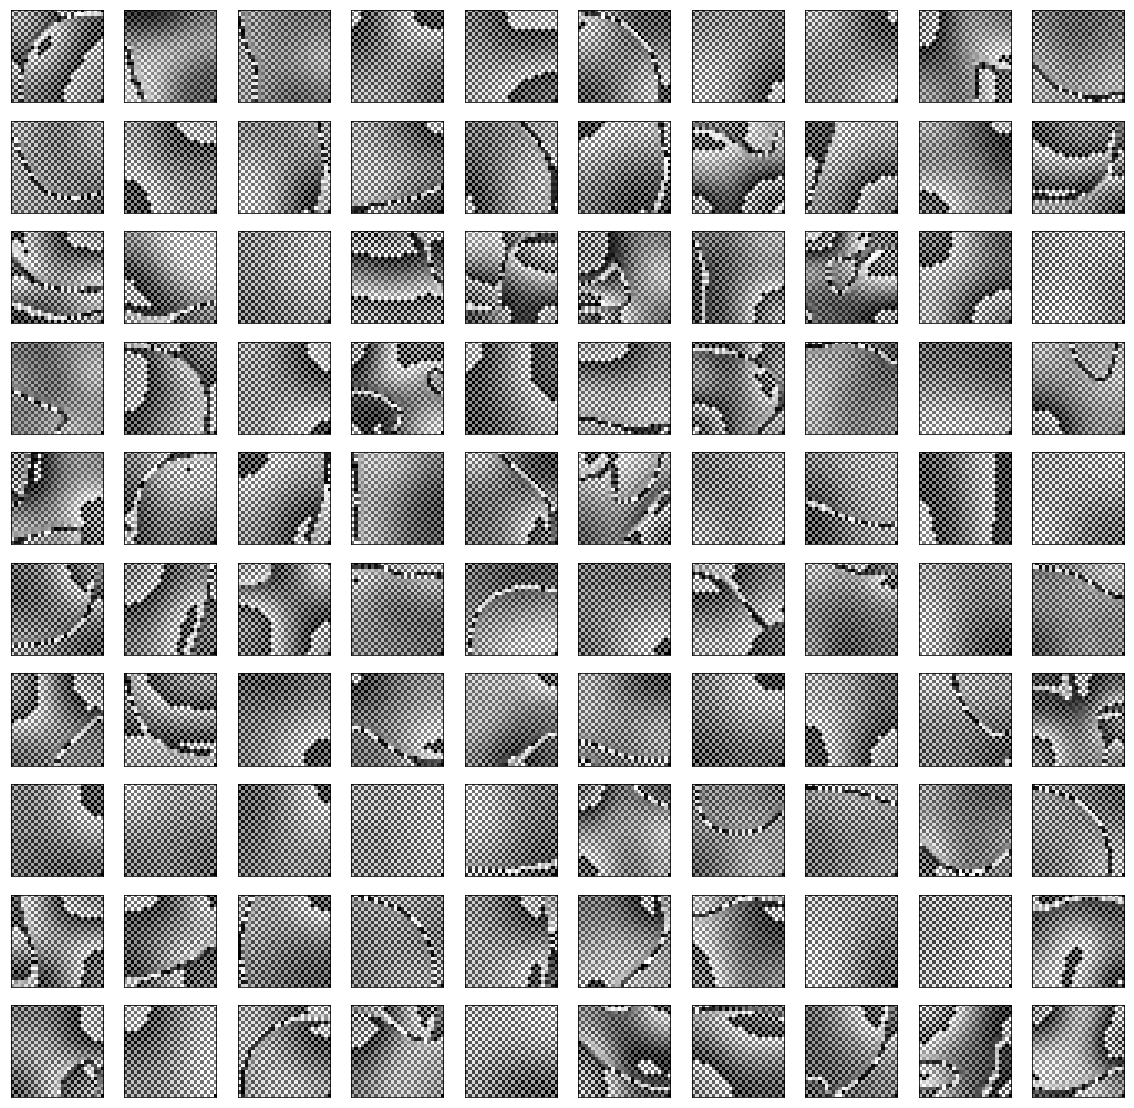

In [122]:
n = 100  
plt.figure(figsize=(20, 20))
for i in range(n):
    ax = plt.subplot(10, 10, i + 1)
    plt.imshow(atoms[i, :,:])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [123]:
dir_models='../ShallowAE/Sparse/Models/'
model_path= dir_models + 'kl_dim100.h5'
autoencoder.save(model_path)

In [125]:
from keras.utils import CustomObjectScope
from keras.models import load_model

autoencoder = load_model(model_path, custom_objects={'KL_divergence':KL_divergence})

In [127]:
encoder = autoencoder.layers[1]
decoder = autoencoder.layers[2]

In [128]:
H = encoder.predict(x_test)
x_reconstruction_test = decoder.predict(H) 

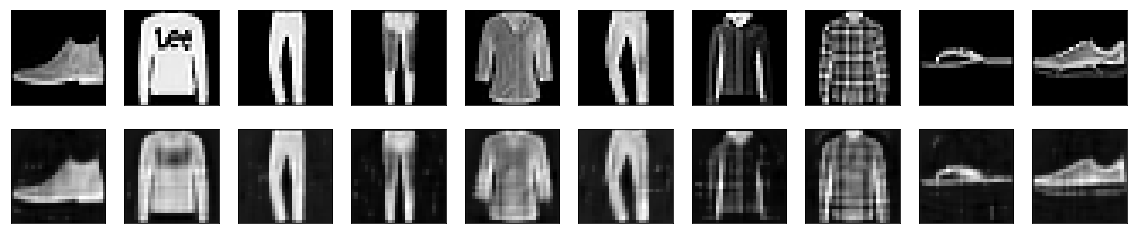

In [129]:
n = 10  # how many images we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i, :,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  
    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(x_reconstruction_test[i,:,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)    
plt.show()

In [130]:
atoms = atom_images(encoder)

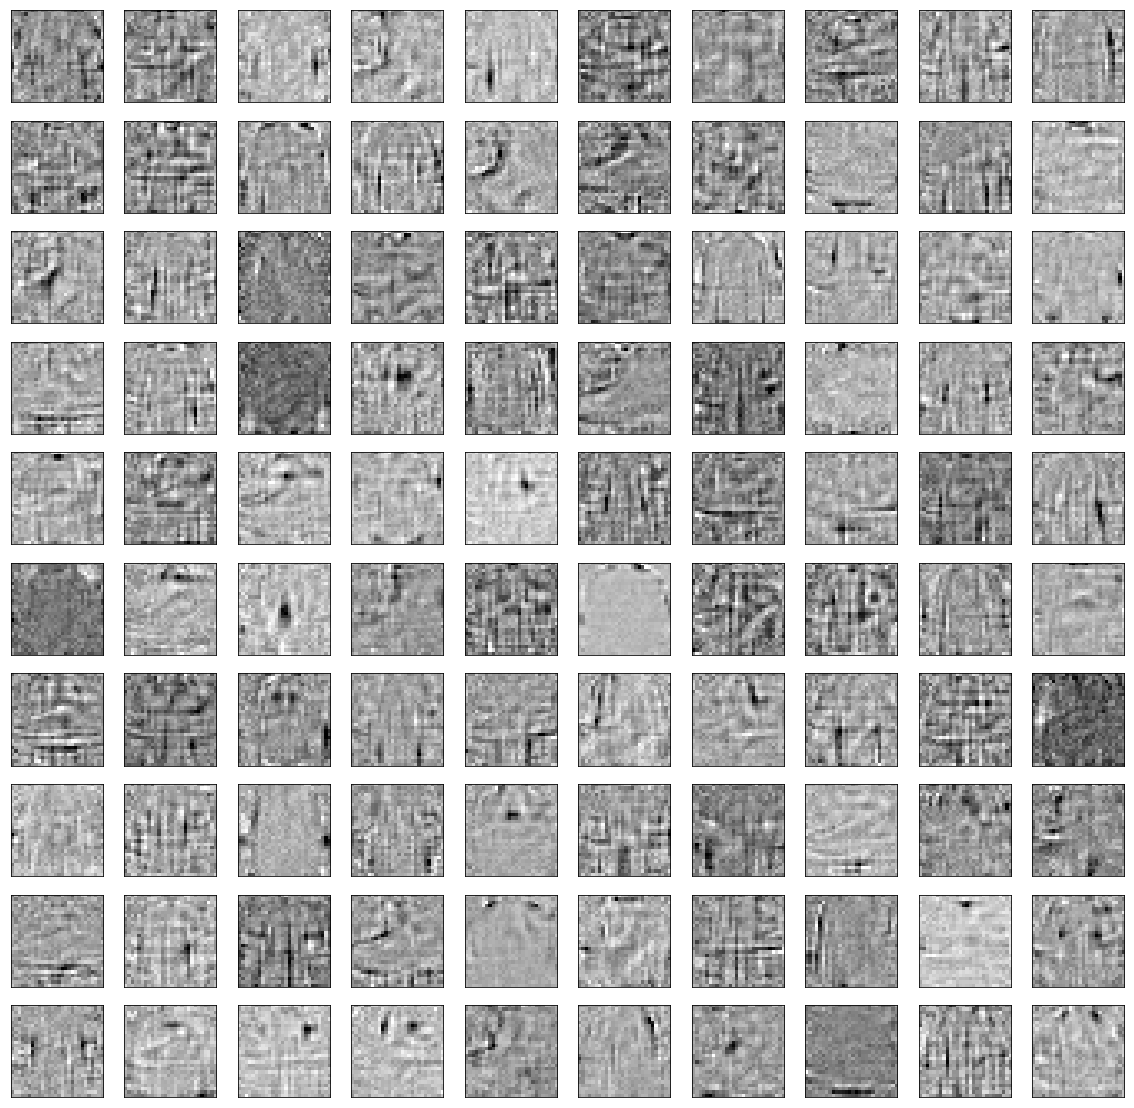

In [131]:
n = 100  
plt.figure(figsize=(20, 20))
for i in range(n):
    ax = plt.subplot(10, 10, i + 1)
    plt.imshow(atoms[:, :,i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()